# ImpDAR Getting Started Tutorial

Welcome!

This is a jupyter binder 
If you want to get ImpDAR running locally on your machine go here...

In [24]:
from impdar.lib import load

import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib notebook

In [37]:
# Loading Data
files = glob.glob('./impdar/tests/input_data/negis_example_data/*[!.gps]')
dat = load.load('gecko',files)[0]

In [38]:
dat.vertical_band_pass(1,5)

Bandpassing from  1.0 to  5.0 MHz...
Bandpass filter complete.


<IPython.core.display.Javascript object>


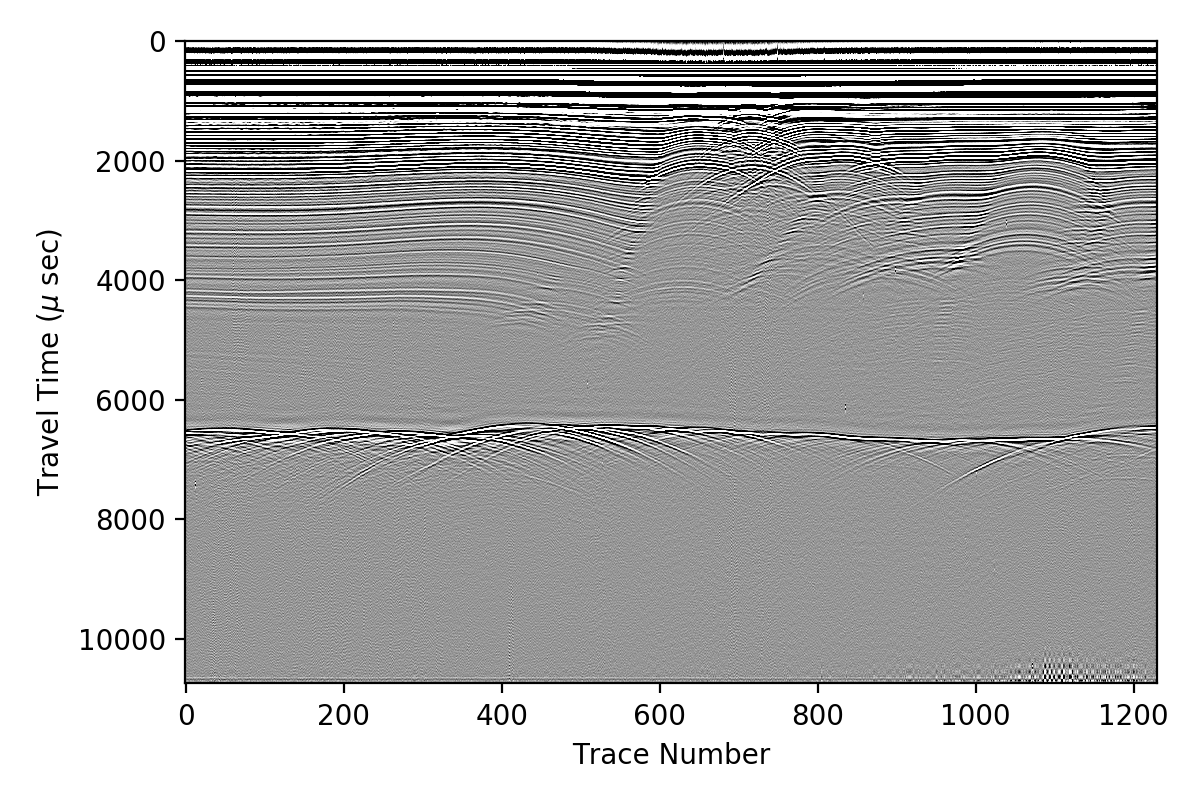

In [39]:
plt.figure(figsize=(6,4))
plt.imshow(dat.data,cmap='Greys',aspect='auto',vmin=-10,vmax=10)
plt.ylabel('Travel Time ($\mu$ sec)')
plt.xlabel('Trace Number')
plt.tight_layout()
plt.show()

In [40]:
dat.crop(0,dimension='pretrig')

Vertical samples reduced to subset [512:10752] of original


<IPython.core.display.Javascript object>


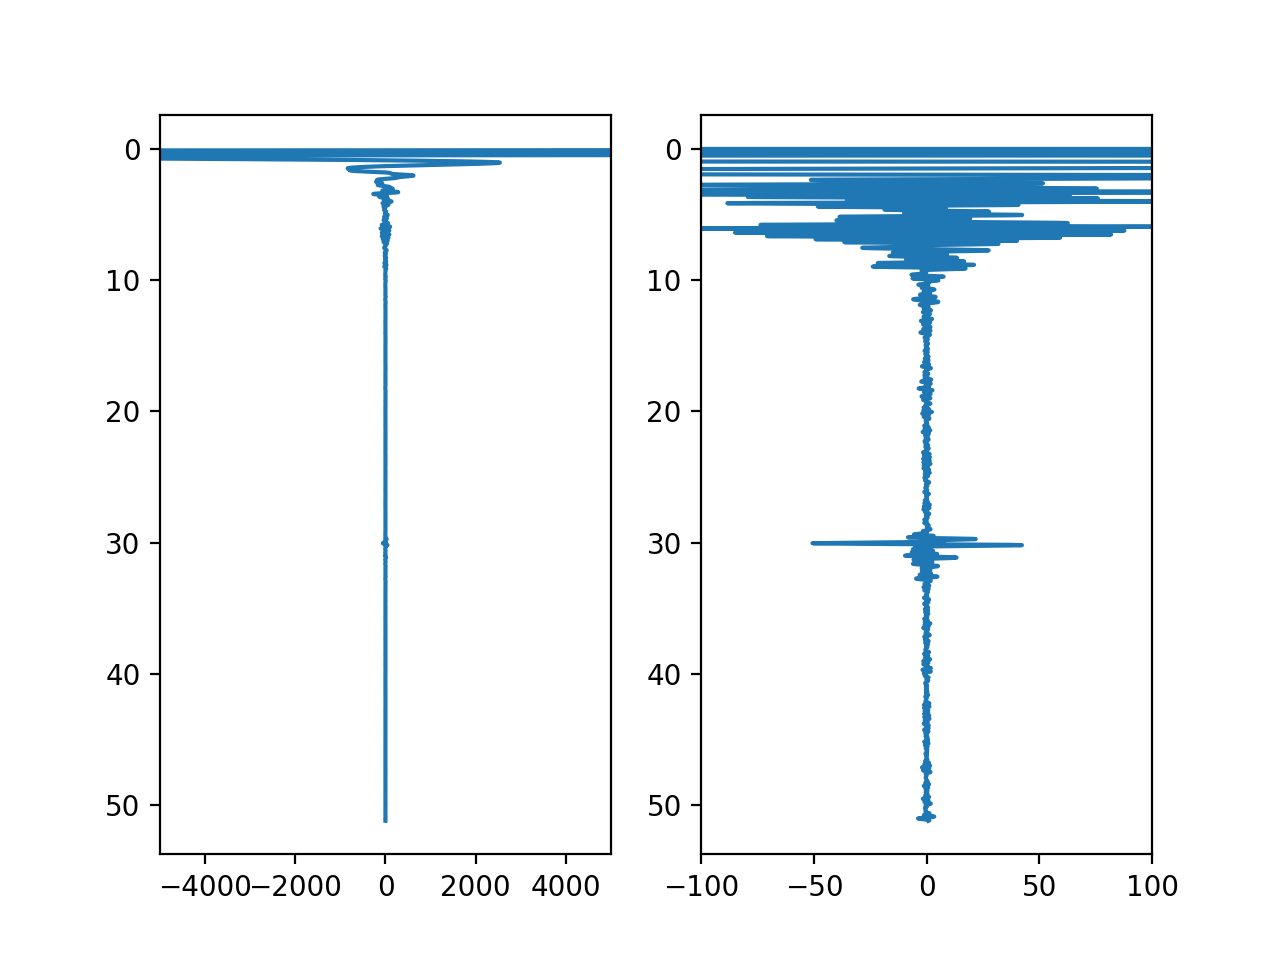

Bandpassing from  1.0 to  5.0 MHz...
Bandpass filter complete.


In [41]:
trace = dat.data[:,600]

plt.figure()
ax1 = plt.subplot(121)
plt.plot(trace,dat.travel_time)
plt.xlim(-5000,5000)
plt.gca().invert_yaxis()

dat.vertical_band_pass(1,5)
trace = dat.data[:,600]

ax2 = plt.subplot(122)
plt.plot(trace,dat.travel_time)
plt.xlim(-100,100)
plt.gca().invert_yaxis()

<IPython.core.display.Javascript object>


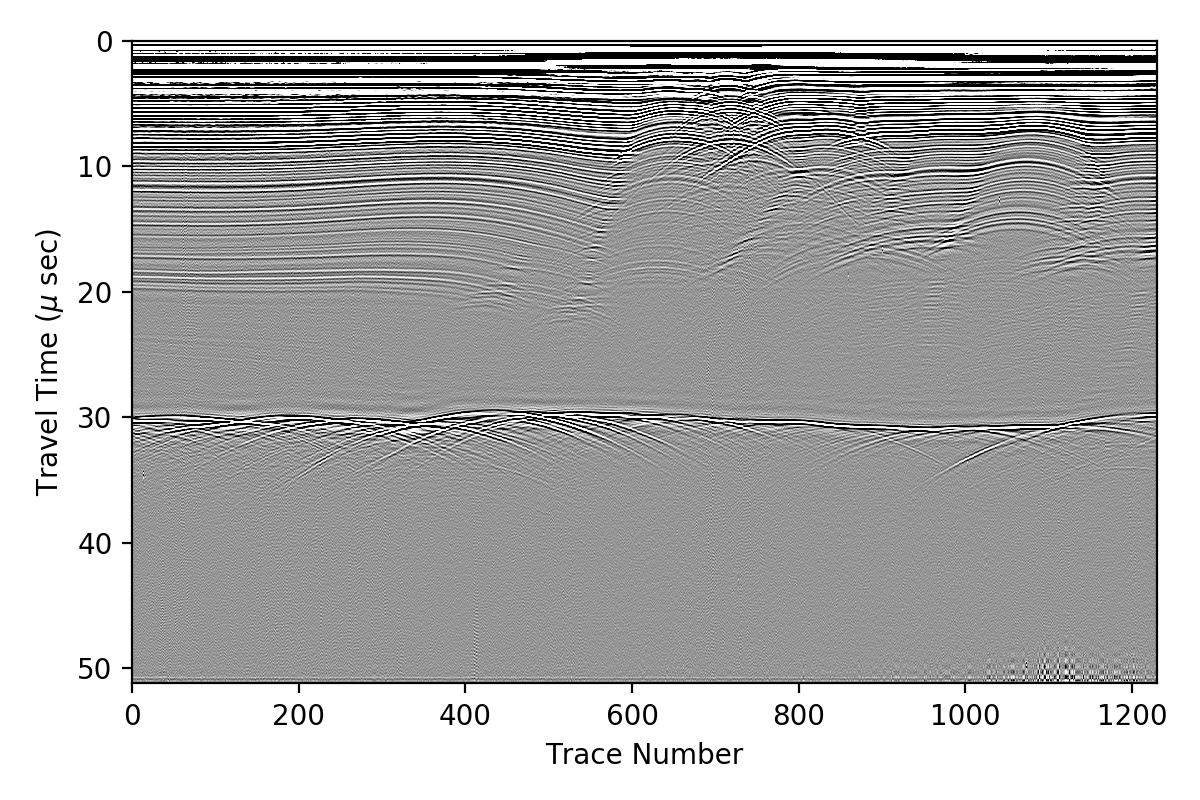

In [42]:
plt.figure(figsize=(6,4))
plt.imshow(dat.data,cmap='Greys',vmin=-10,vmax=10,aspect='auto',
          extent=[0,dat.tnum,max(dat.travel_time),min(dat.travel_time)])
plt.ylabel('Travel Time ($\mu$ sec)')
plt.xlabel('Trace Number')
plt.tight_layout()
plt.show()

In [43]:
dat.nmo(160)
from impdar.lib.gpslib import interp
interp([dat],3,guess_offset=False)
dat.denoise(vert_win=1,hor_win=5)

<IPython.core.display.Javascript object>


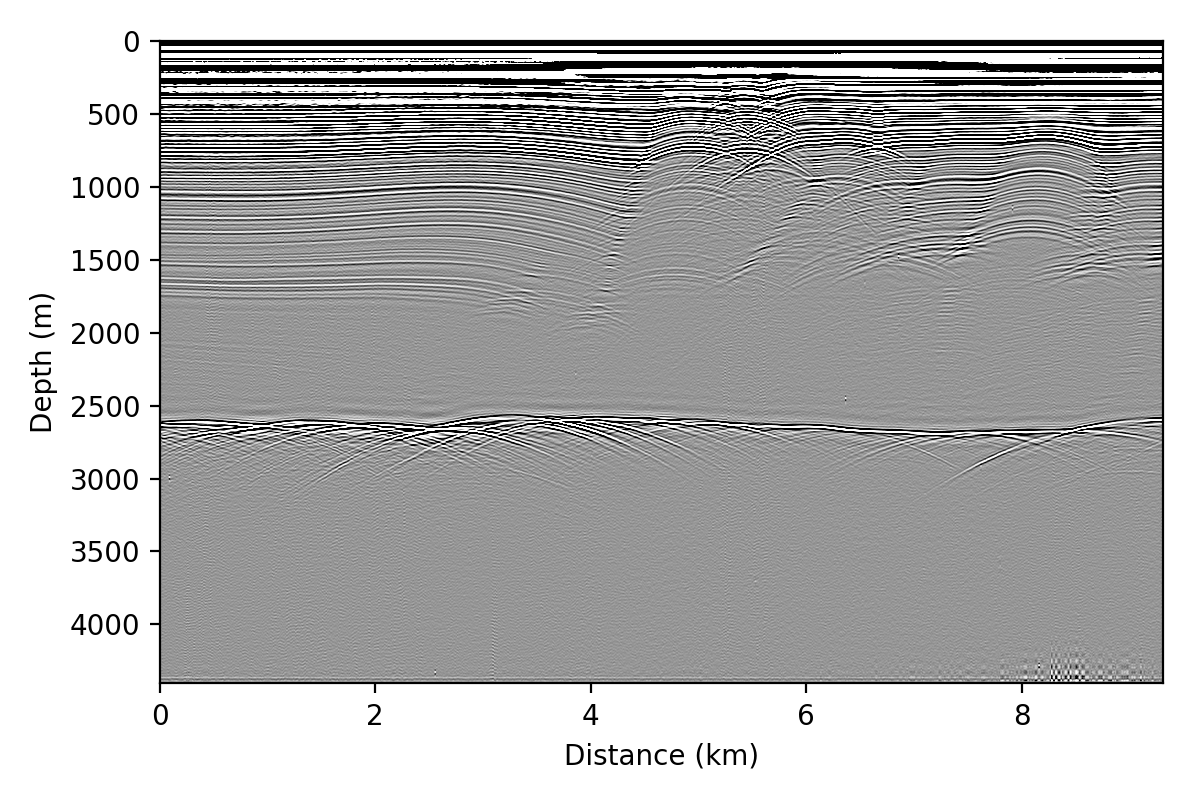

In [44]:
plt.figure(figsize=(6,4))
plt.imshow(dat.data,cmap='Greys',vmin=-10,vmax=10,aspect='auto',
          extent=[min(dat.dist),max(dat.dist),max(dat.nmo_depth),min(dat.nmo_depth)])
plt.ylabel('Depth (m)')
plt.xlabel('Distance (km)')
plt.tight_layout()
plt.show()